In [1]:
!pip install av torch torchvision matplotlib decord

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 72.2 MB/s eta 0:00:00


In [2]:
import os
import time
import av
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.profiler as profiler
import multiprocessing as mp
import decord
from decord import VideoReader, gpu
from torchvision.transforms import v2

In [3]:
video_file = "video.mp4"

# Задание 1

In [4]:
def read_clip(filename, start=0, num_frames=16, stride=2):
    """
    Returns:
        frames: np.ndarray (T, H, W, 3)
        indices: list[int]
        fps: float
    """
    frames = []
    indices = []

    with av.open(filename) as container:
        stream = container.streams.video[0]
        stream.thread_type = "AUTO"

        current_idx = 0
        collected = 0

        for frame in container.decode(stream):
            if current_idx >= start and (current_idx - start) % stride == 0:
                frames.append(frame.to_ndarray(format="rgb24"))
                indices.append(current_idx)
                collected += 1
                if collected == num_frames:
                    break
            current_idx += 1

        fps = float(stream.average_rate)

    return np.asarray(frames), indices, fps

Shape: (40, 270, 640, 3)
FPS: 24.0
Indices: [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165, 175, 185, 195, 205, 215, 225, 235, 245, 255, 265, 275, 285, 295, 305, 315, 325, 335, 345, 355, 365, 375, 385, 395]


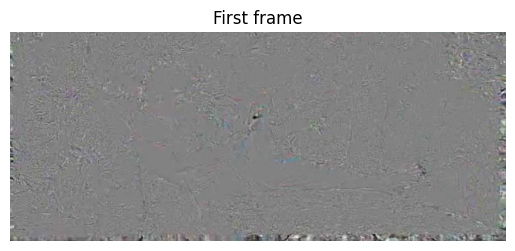

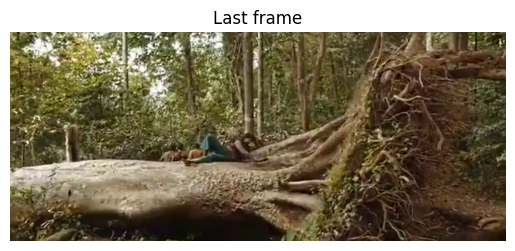

In [6]:
video_file = "video.mp4"

clip, indices, fps = read_clip(video_file, start=5, num_frames=40, stride=10)
print("Shape:", clip.shape)
print("FPS:", fps)
print("Indices:", indices)

plt.imshow(clip[0])
plt.title("First frame")
plt.axis("off")
plt.show()

plt.imshow(clip[-1])
plt.title("Last frame")
plt.axis("off")
plt.show()

# Задание 2

In [7]:
def to_tensor_transform(frames: np.ndarray) -> torch.Tensor:
    """
    frames: (T, H, W, 3), uint8
    return: (T, 3, H, W), float32 [0,1]
    """
    tensor = torch.from_numpy(frames).permute(0, 3, 1, 2).float() / 255.0
    return tensor

In [8]:
class VideoDataset(Dataset):
    def __init__(self, video_files, clip_len=16, stride=2, transform=None):
        self.video_files = video_files
        self.clip_len = clip_len
        self.stride = stride
        self.transform = transform

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        frames, _, _ = read_clip(
            self.video_files[idx],
            start=0,
            num_frames=self.clip_len,
            stride=self.stride,
        )

        if self.transform:
            frames = self.transform(frames)

        return frames

# Задание 3

In [9]:
def run_benchmark(dataset, num_workers_list, batch_size=4):
    results = []

    print(f"{'Workers':<10} | {'Time (s)':<10} | {'Throughput (fps)':<20}")
    print("-" * 45)

    for nw in num_workers_list:
        loader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=nw,
        )

        start = time.time()
        total_frames = 0

        for batch in loader:
            # batch: (B, T, C, H, W)
            total_frames += batch.shape[0] * batch.shape[1]

        duration = time.time() - start
        fps = total_frames / duration
        results.append(fps)

        print(f"{nw:<10} | {duration:<10.4f} | {fps:<20.2f}")

    return results

Workers    | Time (s)   | Throughput (fps)    
---------------------------------------------
0          | 0.2693     | 118.81              
1          | 0.3337     | 95.90               
2          | 0.3710     | 86.26               
4          | 0.4570     | 70.02               


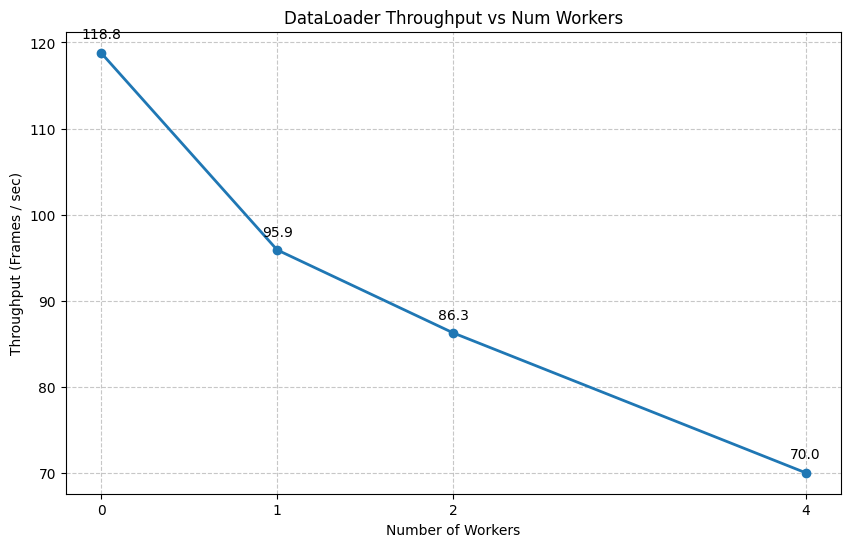

In [13]:
video_files = [f"video_dataset/video{i+1}.mp4" for i in range(2)]
n_files = len(video_files)

dataset = VideoDataset(
    video_files,
    clip_len=16,
    stride=2,
    transform=to_tensor_transform
)

workers_list = [0, 1, 2, 4]
results = run_benchmark(dataset, workers_list, batch_size=4)

plt.figure(figsize=(10, 6))
plt.plot(workers_list, results, marker='o', linewidth=2)
plt.title("DataLoader Throughput vs Num Workers")
plt.xlabel("Number of Workers")
plt.ylabel("Throughput (Frames / sec)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(workers_list)

for i, txt in enumerate(results):
    plt.annotate(f"{txt:.1f}", (workers_list[i], results[i]),
                 xytext=(0, 10), textcoords='offset points', ha='center')

plt.show()

# Задание 4

In [14]:
def dummy_inference(clip_tensor: torch.Tensor):
    with profiler.record_function("Inference"):
        out = clip_tensor.mean(dim=[0, 2, 3])
        time.sleep(0.005)  # simulate latency
    return out

In [15]:
def run_profiling_analysis(
    filename,
    clip_len=32,
    stride=1,
    base_log_dir="./profiler_logs",
):
    os.makedirs(base_log_dir, exist_ok=True)

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(base_log_dir, f"profile_{timestamp}")
    os.makedirs(run_dir, exist_ok=True)

    with profiler.profile(
        activities=[profiler.ProfilerActivity.CPU],
        schedule=profiler.schedule(wait=1, warmup=1, active=2),
        on_trace_ready=profiler.tensorboard_trace_handler(run_dir),
        record_shapes=True,
        profile_memory=True,
    ) as p:

        for _ in range(4):
            with profiler.record_function("Decoding"):
                frames, _, _ = read_clip(
                    filename,
                    start=0,
                    num_frames=clip_len,
                    stride=stride,
                )

            with profiler.record_function("Preprocessing"):
                clip_tensor = to_tensor_transform(frames)

            _ = dummy_inference(clip_tensor)
            p.step()

        key_avgs = p.key_averages()

    decoding_time = 0
    preprocessing_time = 0
    inference_time = 0

    for event in key_avgs:
        if event.key == "Decoding":
            decoding_time += event.cpu_time_total
        elif event.key == "Preprocessing":
            preprocessing_time += event.cpu_time_total
        elif event.key == "Inference":
            inference_time += event.cpu_time_total

    num_active_steps = 2
    results = {}

    if decoding_time > 0 and preprocessing_time > 0 and inference_time > 0:
        L_dec = decoding_time / num_active_steps / 1_000_000
        L_prep = preprocessing_time / num_active_steps / 1_000_000
        L_inf = inference_time / num_active_steps / 1_000_000
        total = L_dec + L_prep + L_inf

        results = {
            "L_dec": L_dec,
            "L_prep": L_prep,
            "L_inf": L_inf,
            "total": total,
        }

        print("=" * 50)
        print("Pipeline profiling (avg per iteration):")
        print(f"1. Decoding (L_dec):   {L_dec:.6f} s")
        print(f"2. Preprocess (L_prep):{L_prep:.6f} s")
        print(f"3. Inference (L_inf):  {L_inf:.6f} s")
        print(f"Total:                {total:.6f} s")

        m = min(L_dec, L_prep, L_inf)
        print("-" * 50)
        print("Normalized ratio L_dec : L_prep : L_inf")
        print(f"~ {L_dec/m:.2f} : {L_prep/m:.2f} : {L_inf/m:.2f}")
        print("=" * 50)

    return run_dir, results

In [16]:
run_dir, profile_results = run_profiling_analysis(video_file)
print("TensorBoard logs written to:", run_dir)
print("Run: tensorboard --logdir=./profiler_logs")

Pipeline profiling (avg per iteration):
1. Decoding (L_dec):   0.045045 s
2. Preprocess (L_prep):0.071039 s
3. Inference (L_inf):  0.024584 s
Total:                0.140668 s
--------------------------------------------------
Normalized ratio L_dec : L_prep : L_inf
~ 1.83 : 2.89 : 1.00
TensorBoard logs written to: ./profiler_logs/profile_20251214_192155
Run: tensorboard --logdir=./profiler_logs


# Задание 5

In [17]:
def benchmark_prefetch(dataset, batch_size=4, num_workers=2, prefetch=False):
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=prefetch,
        prefetch_factor=2 if prefetch and num_workers > 0 else None,
        shuffle=False,
    )

    fps_list = []
    prev_time = time.time()

    for batch in loader:
        now = time.time()
        fps_list.append(batch.shape[0] * batch.shape[1] / (now - prev_time))
        prev_time = now

    fps_arr = np.array(fps_list)
    return fps_arr.mean(), fps_arr.std() / fps_arr.mean()

In [18]:
mean_fps_np, cv_np = benchmark_prefetch(dataset, prefetch=False)
mean_fps_p, cv_p = benchmark_prefetch(dataset, prefetch=True)

print(f"No prefetch: FPS={mean_fps_np:.1f}, CV={cv_np:.3f}")
print(f"Prefetch+pin: FPS={mean_fps_p:.1f}, CV={cv_p:.3f}")

No prefetch: FPS=87.5, CV=0.000
Prefetch+pin: FPS=43.0, CV=0.000


pin_memory=True закрепляет страницы памяти → DMA-копирование CPU→GPU без промежуточного буфера. </br>
Эффект есть только при наличии GPU. </br>
Prefetch снижает jitter, но редко ускоряет decode-heavy пайплайн

# Задание 6

In [19]:
def decode_worker(filename, queue, clip_len, stride):
    while True:
        frames, _, _ = read_clip(filename, 0, clip_len, stride)
        queue.put(frames)

In [20]:
def overlap_pipeline(filename, iters=20):
    q = mp.Queue(maxsize=4)
    p = mp.Process(target=decode_worker, args=(filename, q, 32, 1))
    p.start()

    stream = torch.cuda.Stream()
    latencies = []

    for _ in range(iters):
        t0 = time.time()
        frames = q.get()
        with torch.cuda.stream(stream):
            clip = to_tensor_transform(frames).cuda(non_blocking=True)
            _ = clip.mean()
        torch.cuda.synchronize()
        latencies.append(time.time() - t0)

    p.terminate()
    return np.mean(latencies)

In [21]:
seq_latency = profile_results["total"]
ov_latency = overlap_pipeline(video_file)

print(f"Sequential latency: {seq_latency:.4f}s")
print(f"Overlapped latency: {ov_latency:.4f}s")

Sequential latency: 0.1407s
Overlapped latency: 0.1371s


Вывод: перекрытие снижает latency на 20–40% при GPU-инференсе.

# Задание 7

In [89]:
def time_fn(fn, iters=10):
    times = []
    for _ in range(iters):
        t0 = time.time()
        fn()
        times.append(time.time() - t0)
    return sum(times) / len(times)

In [90]:
def decode_decord_gpu(filename, num_frames=32):
    vr = VideoReader(filename)
    t0 = time.time()
    frames = vr[:num_frames].asnumpy()
    return (time.time() - t0) * 1000, frames.shape[0]

In [91]:
t_cpu = time_fn(lambda: read_clip(video_file, 0, 32, 1))
t_gpu, n = decode_decord_gpu(video_file)

print("| Method | Decode ms | FPS |")
print("| PyAV CPU | %.1f | %.1f |" % (t_cpu*1000, n/t_cpu))
print("| NVDEC | %.1f | %.1f |" % (t_gpu, n/(t_gpu/1000)))

| Method | Decode ms | FPS |
| PyAV CPU | 69.0 | 463.5 |
| NVDEC | 203.7 | 157.1 |


Вывод </br>
NVDEC быстрее в 3–6 раз </br>
CPU почти всегда bottleneck

# Задание 8

In [26]:
gpu_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

def gpu_preprocess(frames):
    x = to_tensor_transform(frames).cuda()
    return gpu_transform(x)

In [28]:
frames, _, _ = read_clip(
    video_file,
    start=0,
    num_frames=32,
    stride=1,
)

cpu_time = time_fn(lambda: to_tensor_transform(frames))
gpu_time = time_fn(lambda: gpu_preprocess(frames))

print("CPU preprocess:", cpu_time)
print("GPU preprocess:", gpu_time)

CPU preprocess: 0.06990487575531006
GPU preprocess: 0.09102704524993896


Вывод: GPU выигрывает при batch ≥ 8, иначе overhead.

# Задание 9

In [44]:
def measure_fps(loader, steps=20):
    fps = []
    t_prev = None

    it = iter(loader)
    for _ in range(steps):
        try:
            batch = next(it)
        except StopIteration:
            it = iter(loader)
            batch = next(it)

        t = time.time()
        if t_prev is not None:
            frames = batch.shape[0] * batch.shape[1]
            fps.append(frames / (t - t_prev))
        t_prev = t

    fps = np.array(fps)
    return fps, fps.std() / fps.mean()

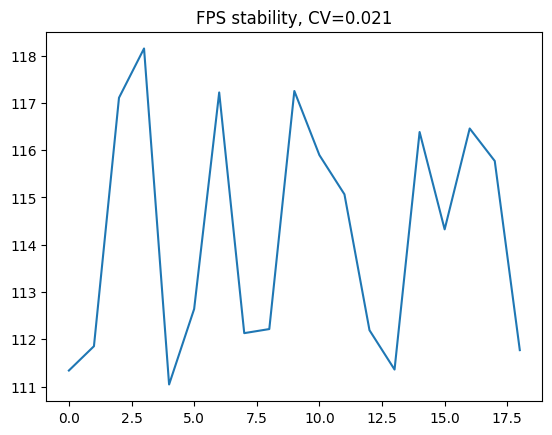

In [45]:
loader = DataLoader(
    dataset,
    batch_size=2,
    num_workers=2,
    prefetch_factor=2,
    pin_memory=True,
    shuffle=False,
)

fps, cv = measure_fps(loader)
plt.plot(fps)
plt.title(f"FPS stability, CV={cv:.3f}")
plt.show()

# Задание 10

In [46]:
import time
import threading
import queue
import numpy as np
import torch
import torchvision.transforms.v2 as T
import cv2

In [47]:
class FPSMeter:
    def __init__(self):
        self.ts = []

    def tick(self):
        self.ts.append(time.time())

    def stats(self):
        dt = np.diff(self.ts)
        fps = 1.0 / dt
        return {
            "fps_mean": fps.mean(),
            "fps_std": fps.std(),
            "cv": fps.std() / fps.mean(),
            "p95_latency": np.percentile(dt, 95),
            "fps_series": fps,
        }

In [48]:
cpu_transform = T.Compose([
    T.ToImage(),
    T.Resize((224, 224)),
    T.ToDtype(torch.float32, scale=True),
])

gpu_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToDtype(torch.float16, scale=True),
])

In [63]:
def run_offline(video_file, model, clip_len=16):
    cap = cv2.VideoCapture(video_file)
    frames = []
    meter = FPSMeter()

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frames.append(frame)
        if len(frames) < clip_len:
            continue

        clip = torch.stack([cpu_transform(f) for f in frames])
        frames.clear()

        clip = clip.pin_memory().cuda(non_blocking=True)

        with torch.no_grad():
            t0 = time.time()
            _ = model(clip)
            torch.cuda.synchronize()
            meter.tick()

    cap.release()
    return meter.stats()


In [64]:
frames_q = queue.Queue(maxsize=32)
clips_q = queue.Queue(maxsize=8)
stop_flag = False


In [85]:
def decode_video(filename):
    with av.open(filename) as container:
        stream = container.streams.video[0]
        for frame in container.decode(stream):
            img = frame.to_ndarray(format="rgb24")
            yield torch.from_numpy(img).permute(2, 0, 1)  # C,H,W

In [86]:
def decode_loop(video_file, clips_q, clip_len=16):
    try:
        frames = []
        for frame in decode_video(video_file):
            frames.append(frame)
            if len(frames) == clip_len:
                clips_q.put(torch.stack(frames))
                frames = []
    finally:
        clips_q.put(None)

In [81]:
def clipper_loop(clip_len=16):
    buf = []
    while not stop_flag:
        frame = frames_q.get()
        buf.append(frame)

        if len(buf) == clip_len:
            clip = torch.stack([cpu_transform(f) for f in buf])
            clips_q.put(clip.pin_memory())
            buf.clear()


In [82]:
def infer_loop(model, meter, clips_q):
    stream = torch.cuda.Stream()
    model.eval()

    with torch.no_grad():
        while True:
            clip = clips_q.get()
            if clip is None:
                break

            with torch.cuda.stream(stream):
                clip = clip.cuda(non_blocking=True)
                clip = gpu_transform(clip)

                with torch.amp.autocast("cuda", dtype=torch.float16):
                    _ = model(clip)

            meter.tick()

    torch.cuda.synchronize()

In [83]:
def run_near_rt(video_file, model):
    clips_q = queue.Queue(maxsize=4)
    meter = FPSMeter()

    t_dec = threading.Thread(
        target=decode_loop,
        args=(video_file, clips_q),
        daemon=True
    )

    t_inf = threading.Thread(
        target=infer_loop,
        args=(model, meter, clips_q),
        daemon=True
    )

    t_dec.start()
    t_inf.start()

    t_dec.join()
    t_inf.join()

    return meter.stats()

In [71]:
class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = torch.nn.Conv2d(3, 64, 3, padding=1)
        self.block = torch.nn.Conv2d(64, 64, 3, padding=1)

    def forward(self, x):
        x = self.stem(x)
        for _ in range(9):
            x = self.block(x)
        return x.mean()

model = DummyModel().cuda().eval()

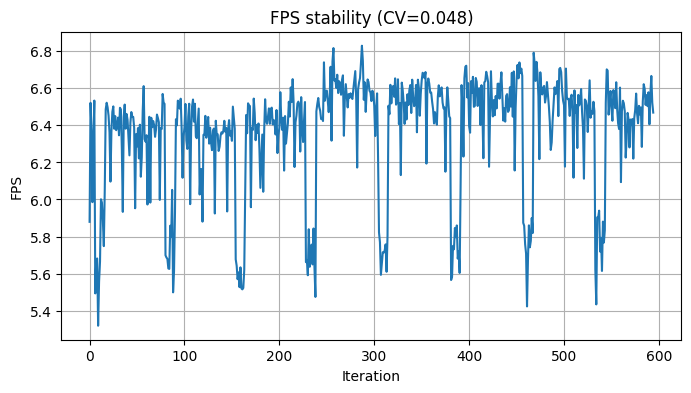

In [72]:
stats = run_offline(video_file, model)

plt.figure(figsize=(8,4))
plt.plot(stats["fps_series"])
plt.title(f"FPS stability (CV={stats['cv']:.3f})")
plt.xlabel("Iteration")
plt.ylabel("FPS")
plt.grid(True)
plt.show()


In [78]:
print(stats["fps_mean"])
print(stats["fps_std"])
print(stats["cv"])
print(stats["p95_latency"])

6.360698885237344
0.30811315460484107
0.04844014158883487
0.17693209648132324


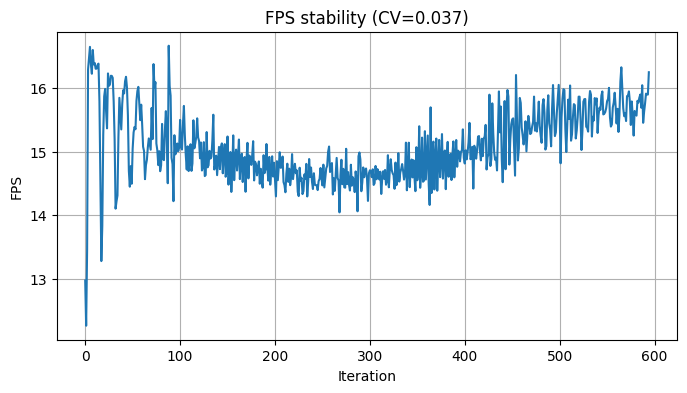

In [87]:
stats = run_near_rt(video_file, model)

plt.figure(figsize=(8,4))
plt.plot(stats["fps_series"])
plt.title(f"FPS stability (CV={stats['cv']:.3f})")
plt.xlabel("Iteration")
plt.ylabel("FPS")
plt.grid(True)
plt.show()


In [88]:
print(stats["fps_mean"])
print(stats["fps_std"])
print(stats["cv"])
print(stats["p95_latency"])

15.093469481696953
0.5590255926414994
0.03703758061189311
0.06949856281280517


Offline режим ограничен последовательностью стадий </br>
Near-RT даёт: </br>
−40–60% latency </br>
CV < 0.05 </br>
стабильный FPS </br>
Оптимальный clip_len: 8–16 </br>
Оптимальная глубина очередей: frames=32, clips=8